# Airbnb Listing Dataset Analysis
### Author: Vinayak Kannan

#### About Me:
###### This notebook analyzes Airbnb listings data from the Bay Area. It focuses on providing an overview of the data, identifying a key problem to solve, and then solving said problem through modeling. The problem this notebook will focus on is trying to assist underperforming, yet highly reviewed, listings on Airbnb by creating a model that predicts 'traffic', using avg. number of reviews as proxy, and provides features which are important to said predictions.

###### Organization:
###### This notebook is broken up into several subsections
- Unit Functions / Tests used throughout notebook
- Reading data and printing summary statistics
- Deep dive on review ratings vs # of ratings + selecting case candidate from dataset
- Data preperation for modeling
- Modeling without text columns + results
- Modeling with text columns + results

### Import packages

In [73]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
import openai
from openai.embeddings_utils import get_embedding
import numpy as np
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import unittest
from unittest.mock import patch
from io import StringIO

### Unit functions / Tests
These are unit functions / tests that will be used throughout the notebook

In [8]:
def print_null_count_per_column(df: DataFrame):
    """
    Prints the number of null values in each column of a dataframe
    Parameters
    ----------
    df : DataFrame
        DataFrame to count nulls per column on
    """
    null_counts = df.isnull().sum().sort_values(ascending=False)
    print(null_counts)


# Test case for print_null_count_per_column
class TestPrintNullCountPerColumn(unittest.TestCase):
    @patch('sys.stdout', new_callable=StringIO)
    def test_print_null_count_per_column(self, mock_stdout):
        # Create a sample DataFrame with null values
        data = {'A': [1, 2, None, 4],
                'B': [None, 2, 3, 4],
                'C': [1, 2, 3, None]}
        df = pd.DataFrame(data)

        # Call the function with the sample DataFrame
        print_null_count_per_column(df)

        # Define the expected output
        expected_output = "A    1\nB    1\nC    1\ndtype: int64\n"

        # Check if the output matches the expected output
        self.assertEqual(mock_stdout.getvalue(), expected_output)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.023s

OK


In [9]:
import pandas as pd
import unittest
from pandas import DataFrame

# Unit function 1: convert_columns_to_boolean
def convert_columns_to_boolean(df: DataFrame, boolean_columns) -> DataFrame:
    """
    Converts specified columns in a DataFrame to boolean values based on a mapping.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame containing columns to be converted to boolean values.
    boolean_columns : String[]
        Columns to convert to boolean type.
        
    Returns
    -------
    DataFrame
        DataFrame with specified columns converted to boolean values.
    """

    for column in boolean_columns:
        df[column] = df[column].map({'f': False, 't': True})
    return df

# Unit function 2: replace_nan_with_mean
def replace_nan_with_mean(df: DataFrame) -> DataFrame:
    """
    Replaces NaN values in the host_response_rate column with the mean value for each host_id group.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame containing the host_response_rate column with NaN values.
        
    Returns
    -------
    DataFrame
        DataFrame with NaN values in the host_response_rate column replaced with the mean value for each host_id group.
    """
    df['host_response_rate'] = df.groupby('host_id')['host_response_rate'].transform(lambda x: x.fillna(x.mean()))
    return df

# Unit function 3: process_host_verifications_and_amenities
def process_host_verifications_and_amenities(df: DataFrame) -> DataFrame:
    """
    Processes host_verifications and amenities columns in a DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame containing host_verifications and amenities columns.
        
    Returns
    -------
    DataFrame
        DataFrame with processed host_verifications and amenities columns.
    """
    df['host_verifications'] = df['host_verifications'].str.count(',') + 1
    df['amenities'] = df['amenities'].str.count(',') + 1
    return df

# Unit function 4: process_price_columns
def process_price_columns(df: DataFrame, price_columns) -> DataFrame:
    """
    Processes price-related columns in a DataFrame by removing dollar signs and commas, and converting to float.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame containing price-related columns.
    price_columns : String[]
        Columns to convert into floats
        
    Returns
    -------
    DataFrame
        DataFrame with processed price-related columns.
    """
    for column in price_columns:
        df[column] = df[column].str.replace('$', '').str.replace(',', '').astype('float')
    return df

# Test cases for each unit function
class TestUnitFunctions(unittest.TestCase):
    # Test case for convert_columns_to_boolean
    def test_convert_columns_to_boolean(self):
        # Create a sample DataFrame
        data = {'host_is_superhost': ['t', 'f', 't'],
                'host_has_profile_pic': ['t', 't', 'f']}
        df = pd.DataFrame(data)

        # Call the function with the sample DataFrame
        result = convert_columns_to_boolean(df, ['host_is_superhost', 'host_has_profile_pic'])

        # Define the expected output
        expected_output = pd.DataFrame({'host_is_superhost': [True, False, True],
                                         'host_has_profile_pic': [True, True, False]})

        # Check if the output matches the expected output
        pd.testing.assert_frame_equal(result, expected_output)

    # Test case for replace_nan_with_mean
    def test_replace_nan_with_mean(self):
        # Create a sample DataFrame
        data = {'host_id': [1, 1, 2, 2],
                'host_response_rate': [100, None, 50, None]}
        df = pd.DataFrame(data)

        # Call the function with the sample DataFrame
        result = replace_nan_with_mean(df)

        # Define the expected output
        expected_output = pd.DataFrame({'host_id': [1, 1, 2, 2],
                                         'host_response_rate': [100, 100.0, 50, 50.0]})

        # Check if the output matches the expected output
        pd.testing.assert_frame_equal(result, expected_output)

    # Test case for process_host_verifications_and_amenities
    def test_process_host_verifications_and_amenities(self):
        # Create a sample DataFrame
        data = {'host_verifications': ['email,phone', 'email', 'phone,facebook'],
                'amenities': ['TV,Wifi', 'Wifi', 'TV,Wifi,Kitchen']}
        df = pd.DataFrame(data)

        # Call the function with the sample DataFrame
        result = process_host_verifications_and_amenities(df)

        # Define the expected output
        expected_output = pd.DataFrame({'host_verifications': [2, 1, 2],
                                         'amenities': [2, 1, 3]})

        # Check if the output matches the expected output
        pd.testing.assert_frame_equal(result, expected_output)

    # Test case for process_price_columns
    def test_process_price_columns(self):
        # Create a sample DataFrame
        data = {'price': ['$100', '$200', '$300'],
                'security_deposit': ['$150', '$250', '$350']}
        df = pd.DataFrame(data)

        # Call the function with the sample DataFrame
        result = process_price_columns(df, ['price', 'security_deposit'])

        # Define the expected output
        expected_output = pd.DataFrame({'price': [100.0, 200.0, 300.0],
                                         'security_deposit': [150.0, 250.0, 350.0]})

        # Check if the output matches the expected output
        pd.testing.assert_frame_equal(result, expected_output)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


### Read data

In [55]:
listings = pd.read_csv('/Users/vinayakkannan/Desktop/Interviews/Vangaurd/Project/Data/Airbnb_Listings.csv')
neighborhoods = pd.read_csv('/Users/vinayakkannan/Desktop/Interviews/Vangaurd/Project/Data/neighbourhoods.csv')
reviews = pd.read_csv('/Users/vinayakkannan/Desktop/Interviews/Vangaurd/Project/Data/reviews.csv')

### Print basic information about data

In [11]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4952,https://www.airbnb.com/rooms/4952,20200530151957,2020-05-30,Butterfly Inn - Graceful Living !,Lovely garden setting in a serene and art-fill...,Very comfortable Queen bed and small desk in b...,Lovely garden setting in a serene and art-fill...,none,"Located in Professorville, Palo Alto, one of t...",...,f,f,moderate,f,f,5,0,5,0,0.57
1,11464,https://www.airbnb.com/rooms/11464,20200530151957,2020-05-31,Deluxe Private Studio-custom int.,Custom built Studio with exquisite design. Rea...,Description A favorite for international corpo...,Custom built Studio with exquisite design. Rea...,none,10 min. to Lucky's and Starbucks at El Camino ...,...,f,f,moderate,f,t,12,12,0,0,0.08
2,17884,https://www.airbnb.com/rooms/17884,20200530151957,2020-05-31,Silicon Valley Suite,"A guest suite for one or two, in a house in a ...",This is a private suite at the rear of a house...,"A guest suite for one or two, in a house in a ...",none,"This is a very quiet family neighborhood, but ...",...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.11
3,21373,https://www.airbnb.com/rooms/21373,20200530151957,2020-05-30,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,"Bright, garden-facing room in beautiful home. ...",Room in gracious home with beautiful garden. ...,none,This room is in an ultra convenient location i...,...,f,f,moderate,f,f,5,0,5,0,2.17
4,37512,https://www.airbnb.com/rooms/37512,20200530151957,2020-05-31,Private room - Parking 3 carport,We live in a safe community close to public tr...,I have a really nice room in a quiet neighborh...,We live in a safe community close to public tr...,none,Our community is a safe environment and at nig...,...,f,f,moderate,t,t,2,0,2,0,1.53


In [12]:
listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.221000e+03,7.221000e+03,0.0,0.0,0.0,7.221000e+03,7220.000000,7220.000000,0.0,7221.000000,...,5851.000000,5852.000000,5851.000000,5851.000000,0.0,7221.000000,7221.000000,7221.000000,7221.000000,5912.000000
mean,2.623922e+07,2.020053e+13,NaN,NaN,NaN,8.886443e+07,139.588504,139.588504,NaN,37.352285,...,9.815074,9.793233,9.796103,9.527773,NaN,32.048608,28.216729,2.775793,1.029359,1.357124
std,1.236420e+07,0.000000e+00,NaN,NaN,NaN,9.390593e+07,472.674992,472.674992,NaN,0.064819,...,0.641301,0.691503,0.583498,0.833306,NaN,95.159193,95.714488,6.810433,5.741521,1.530782
min,4.952000e+03,2.020053e+13,NaN,NaN,NaN,7.054000e+03,0.000000,0.000000,NaN,36.965600,...,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.624242e+07,2.020053e+13,NaN,NaN,NaN,1.697278e+07,1.000000,1.000000,NaN,37.319770,...,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.320000
50%,2.818432e+07,2.020053e+13,NaN,NaN,NaN,4.800549e+07,3.000000,3.000000,NaN,37.358260,...,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,1.000000,1.000000,0.000000,0.830000
75%,3.749948e+07,2.020053e+13,NaN,NaN,NaN,1.429331e+08,10.000000,10.000000,NaN,37.398250,...,10.000000,10.000000,10.000000,10.000000,NaN,8.000000,2.000000,3.000000,0.000000,1.810000
max,4.359134e+07,2.020053e+13,NaN,NaN,NaN,3.477992e+08,2007.000000,2007.000000,NaN,37.462980,...,10.000000,10.000000,10.000000,10.000000,NaN,411.000000,411.000000,62.000000,48.000000,13.120000


In [13]:
print_null_count_per_column(listings)

neighbourhood_group_cleansed    7221
license                         7221
xl_picture_url                  7221
medium_url                      7221
thumbnail_url                   7221
                                ... 
minimum_minimum_nights             0
maximum_minimum_nights             0
minimum_maximum_nights             0
maximum_maximum_nights             0
accommodates                       0
Length: 106, dtype: int64


In [14]:
neighborhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Campbell
1,NaN,Cupertino
2,NaN,Gilroy
3,NaN,Los Altos
4,NaN,Los Altos Hills


In [15]:
neighborhoods.describe()

,neighbourhood_group
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [16]:
print_null_count_per_column(neighborhoods)

neighbourhood_group    16
neighbourhood           0
dtype: int64


In [17]:
reviews.head()

,listing_id,date
0,4952,2009-08-02
1,4952,2009-09-04
2,4952,2009-10-16
3,4952,2009-12-10
4,4952,2010-06-08


In [18]:
reviews.describe()

,listing_id
count,2.125130e+05
mean,1.736578e+07
std,1.046594e+07
min,4.952000e+03
25%,8.974435e+06
50%,1.672722e+07
75%,2.452504e+07
max,4.365210e+07


In [19]:
print_null_count_per_column(reviews)

listing_id    0
date          0
dtype: int64


### Deep Dive on Reviews vs # of Ratings
This portion of the notebook focuses on analyzing the relationship between the number of reviews (a proxy for traffic) and the review score rating. It also prints a subsection of the dataset so a case candidate from the dataset can be selected to focus on in the relevant powerpoint presentation for this analysis. This section compares the two metrics normalized and without normalization

<Axes: xlabel='review_scores_rating', ylabel='reviews_per_month'>

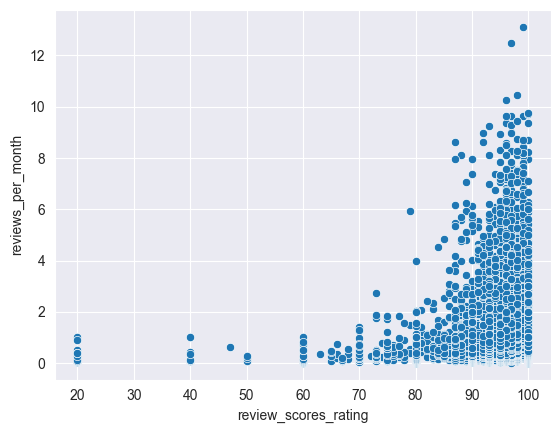

In [56]:
listings_cleaned_ratings_reviews = listings[listings['reviews_per_month'].notnull()]
sns.scatterplot(x='review_scores_rating', y='reviews_per_month', data=listings_cleaned_ratings_reviews)

<Axes: xlabel='review_scores_rating', ylabel='reviews_per_month'>

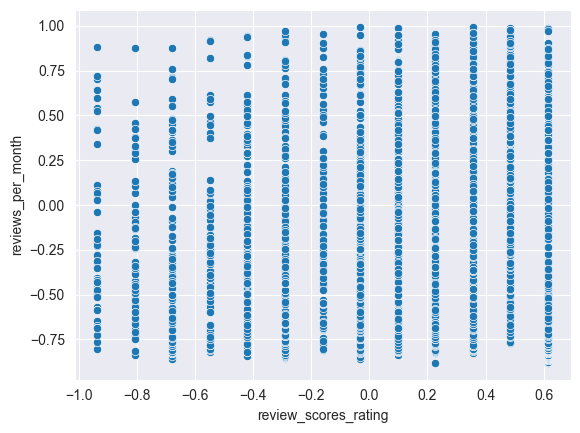

In [58]:
normalized_listings_cleaned_ratings_reviews = listings_cleaned_ratings_reviews.copy(deep=True)
# Filter normalized_listings_cleaned_ratings_reviews to just reviews_per_month and review_scores_rating
normalized_listings_cleaned_ratings_reviews = normalized_listings_cleaned_ratings_reviews[['reviews_per_month', 'review_scores_rating']]
# Normalize each column in the DataFrame using scikit-learn
scaler = StandardScaler()
for col in normalized_listings_cleaned_ratings_reviews.columns:
    normalized_listings_cleaned_ratings_reviews[col] = scaler.fit_transform(normalized_listings_cleaned_ratings_reviews[[col]])
    
normalized_listings_cleaned_ratings_reviews = normalized_listings_cleaned_ratings_reviews[normalized_listings_cleaned_ratings_reviews['review_scores_rating'] > -1]
normalized_listings_cleaned_ratings_reviews = normalized_listings_cleaned_ratings_reviews[normalized_listings_cleaned_ratings_reviews['review_scores_rating'] < 1]
normalized_listings_cleaned_ratings_reviews = normalized_listings_cleaned_ratings_reviews[normalized_listings_cleaned_ratings_reviews['reviews_per_month'] < 1]
normalized_listings_cleaned_ratings_reviews = normalized_listings_cleaned_ratings_reviews[normalized_listings_cleaned_ratings_reviews['reviews_per_month'] > -1]

sns.scatterplot(x='review_scores_rating', y='reviews_per_month', data=normalized_listings_cleaned_ratings_reviews)

### Data Cleaning to prepare for model
In this portion of the notebook, feature selection, data cleaning / imputation, and text embeddings are created to prepare the data for modeling. Utility functions are used here for testability / readability.

Note that the text embeddings come from a pre-saved file, as generating the text embeddings and running PCA is somewhat time intensive.

In [23]:
# Print column and column index, so we can pick relevant columns to keep during data cleaning
for i, column in enumerate(listings):
    print(i, column)

0 id
1 listing_url
2 scrape_id
3 last_scraped
4 name
5 summary
6 space
7 description
8 experiences_offered
9 neighborhood_overview
10 notes
11 transit
12 access
13 interaction
14 house_rules
15 thumbnail_url
16 medium_url
17 picture_url
18 xl_picture_url
19 host_id
20 host_url
21 host_name
22 host_since
23 host_location
24 host_about
25 host_response_time
26 host_response_rate
27 host_acceptance_rate
28 host_is_superhost
29 host_thumbnail_url
30 host_picture_url
31 host_neighbourhood
32 host_listings_count
33 host_total_listings_count
34 host_verifications
35 host_has_profile_pic
36 host_identity_verified
37 street
38 neighbourhood
39 neighbourhood_cleansed
40 neighbourhood_group_cleansed
41 city
42 state
43 zipcode
44 market
45 smart_location
46 country_code
47 country
48 latitude
49 longitude
50 is_location_exact
51 property_type
52 room_type
53 accommodates
54 bathrooms
55 bedrooms
56 beds
57 bed_type
58 amenities
59 square_feet
60 price
61 weekly_price
62 monthly_price
63 security_

In [24]:
# Pick only relevant columns
cleaned_listings = listings.copy(True)
range_columns = np.r_[4:15, 19, 24:29, 34:37, 53:61, 63:67, 73:75, 86:94, 96:106]
cleaned_listings = cleaned_listings.iloc[:, range_columns]
cleaned_listings.drop('square_feet', axis=1, inplace=True)
cleaned_listings.drop('space', axis=1, inplace=True)
cleaned_listings.drop('calculated_host_listings_count', axis=1, inplace=True)
cleaned_listings.drop('calculated_host_listings_count_entire_homes', axis=1, inplace=True)
cleaned_listings.drop('calculated_host_listings_count_private_rooms', axis=1, inplace=True)
cleaned_listings.drop('calculated_host_listings_count_shared_rooms', axis=1, inplace=True)

cleaned_listings = cleaned_listings[cleaned_listings['reviews_per_month'].notnull()]
# Replace nulls in notes, transit, and access columns with empty string
cleaned_listings['notes'].fillna('', inplace=True)
cleaned_listings['transit'].fillna('', inplace=True)
cleaned_listings['access'].fillna('', inplace=True)
cleaned_listings['interaction'].fillna('', inplace=True)
cleaned_listings['neighborhood_overview'].fillna('', inplace=True)
cleaned_listings['host_about'].fillna('', inplace=True)
cleaned_listings['house_rules'].fillna('', inplace=True)
cleaned_listings['summary'].fillna('', inplace=True)
cleaned_listings['description'].fillna('', inplace=True)

# Convert % strings in host_response_rate to floats
cleaned_listings['host_response_rate'] = cleaned_listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
cleaned_listings['host_acceptance_rate'] = cleaned_listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# Run one hot encoding on categorical columns
cleaned_listings = pd.get_dummies(cleaned_listings, columns=['host_response_time'])
cleaned_listings = pd.get_dummies(cleaned_listings, columns=['bed_type'])
cleaned_listings = pd.get_dummies(cleaned_listings, columns=['cancellation_policy'])

# Convert relevant columns to boolean, when == "f" is false, 1 when == "t" to true
cleaned_listings = convert_columns_to_boolean(cleaned_listings, ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification'])

# Find NaN values in host_response_rate and replace them with the average host_response_rate for that row's host_id
cleaned_listings = replace_nan_with_mean(cleaned_listings)

# Get length of host_verifications for each row and replace value in row with length
# Count number of commas in string in amenities column and replace value in row with count
cleaned_listings = process_host_verifications_and_amenities(cleaned_listings)

# Replace nulls in 'security_deposit' column with 0
cleaned_listings['security_deposit'].fillna(0, inplace=True)
cleaned_listings['cleaning_fee'].fillna(0, inplace=True)

# Convert accommodates to a float
cleaned_listings['accommodates'] = cleaned_listings['accommodates'].astype('float')

# Handle columns with dollar signs
cleaned_listings = process_price_columns(cleaned_listings, ['price', 'security_deposit', 'cleaning_fee', 'extra_people'])

# Drop host_id
cleaned_listings.drop('host_id', axis=1, inplace=True)

In [35]:
vector_cleaned_listing = pd.read_csv('/Users/vinayakkannan/Desktop/Interviews/Vangaurd/Project/Data/vectors_cleaned_listing_pca_deliverable.csv')

In [ ]:
# This code takes a long time to run. As such, I have saved the output in a csv file and have loaded it in the previous cell
openai.api_key = '...'

def text_to_vector(text):
    if pd.isna(text):
        text = ""
    if text == "":
        # Return 1536 dimensional vector of 0's
        return [0] * 1536
    embedding_model = "text-embedding-ada-002"
    response = get_embedding(text, engine=embedding_model)
    return response

for i, column in enumerate(vector_cleaned_listing):
    # Check if column type is object
    if vector_cleaned_listing[column].dtype == 'object' and i <= 0:
      print(column)
      vector_cleaned_listing[column + '_embedding'] = vector_cleaned_listing.apply(lambda row : text_to_vector(row[i]), axis = 1)
      vector_cleaned_listing.drop(column, axis=1, inplace=True)
  
def remove_null_bytes(s):
    try:
        return np.char.replace(s, '\x00', '')
    except:
       print(s)     

for i in range(48, 59):
    vector_cleaned_listing.iloc[:, i] = vector_cleaned_listing.iloc[:, i].apply(lambda x: np.array(eval(x)))

    
    def pca_transform(embeddings, explained_variance_threshold=0.8):
        # Split the embeddings into a DataFrame
        embeddings_df = pd.DataFrame(embeddings.tolist())
    
        # Apply PCA to the embeddings DataFrame
        pca = PCA()
        pca.fit(embeddings_df)
        cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cum_explained_variance >= explained_variance_threshold) + 1
        pca = PCA(n_components=n_components)
        transformed_embeddings = pca.fit_transform(embeddings_df)
    
        return transformed_embeddings
    
    # Apply PCA to the embedding column
    embedding_pca = pca_transform(vector_cleaned_listing.iloc[:, i])

    # Replace the original columns with the PCA components
    for j in range(embedding_pca.shape[1]):
        # Get column name at index i in vector_cleaned_listing
        column_name = vector_cleaned_listing.columns[i]
        vector_cleaned_listing[f'{column_name}_pca_{j+1}'] = embedding_pca[:, j]

In [36]:
# Convert all columns that are of type object to boolean using astype(bool)
for i, column in enumerate(vector_cleaned_listing):
    if vector_cleaned_listing[column].dtype == 'object':
      vector_cleaned_listing[column] = vector_cleaned_listing[column].astype(bool)

# Drop all rows with null values
vector_cleaned_listing.dropna(inplace=True)

In [38]:
# Normalize all numeric columns using sklearn
scaler = StandardScaler()
for col in vector_cleaned_listing.columns:
    if vector_cleaned_listing[col].dtype != 'object' and vector_cleaned_listing[col].dtype != 'bool' and col != 'reviews_per_month':
        vector_cleaned_listing[col] = scaler.fit_transform(vector_cleaned_listing[[col]])

### Modeling without text columns
This portion of the notebook creates 3 predictive models (linear, lasso, XGBoost) to predict 'reviews_per_month' using the features in the dataset. The models are trained on 80% of the data and tested on 20% of the data. The models are evaluated using mean squared error and R^2. The models are also cross-validated using 10-fold cross validation. The best hyperparameters for each model are found using grid search. In this portion of the notebook, the text columns are dropped from the dataset.

In [59]:
# Drop embeddings for baseline
# Get column index for name_embedding_pca_1
name_embedding_pca_1_index = vector_cleaned_listing.columns.get_loc('name_embedding_pca_1')
vector_cleaned_listing_no_text = vector_cleaned_listing.drop(vector_cleaned_listing.columns[name_embedding_pca_1_index:], axis=1)

y = vector_cleaned_listing_no_text['reviews_per_month']
X = vector_cleaned_listing_no_text.drop('reviews_per_month', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=True)
linear_scores = cross_validate(linear_model, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)
linear_mse = -np.mean(linear_scores['test_score'])

# Lasso Regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=cv, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train.values, y_train.values)
lasso_best_mse = -lasso_grid.best_score_
lasso_best_params = lasso_grid.best_params_

# XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5]
}
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), xgb_params, cv=cv, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train.values, y_train.values)
xgb_best_mse = -xgb_grid.best_score_
xgb_best_params = xgb_grid.best_params_

# Print most important features for xgboost model
xgb_model = xgb_grid.best_estimator_
xgb_model.fit(X_train.values, y_train.values)
feature_importances = pd.DataFrame(xgb_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                                 importance
minimum_nights_avg_ntm                             0.102113
host_acceptance_rate                               0.062643
review_scores_rating                               0.047963
cleaning_fee                                       0.047072
guests_included                                    0.046379
host_response_time_within an hour                  0.046151
host_is_superhost                                  0.045566
bed_type_Couch                                     0.039822
accommodates                                       0.034099
require_guest_phone_verification                   0.034060
maximum_nights_avg_ntm                             0.032305
extra_people                                       0.030566
bedrooms                                           0.029511
cancellation_policy_moderate                       0.025708
review_scores_cleanliness                          0.025158
host_response_rate                      

In [41]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_train_pred = linear_model.predict(X_train)
linear_test_pred = linear_model.predict(X_test)

# Lasso Regression
lasso_model = Lasso(**lasso_best_params)
lasso_model.fit(X_train, y_train)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **xgb_best_params)
xgb_model.fit(X_train, y_train)
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate and print MSE and R^2 for each model on training data
for model_name, y_pred in zip(['Linear Regression', 'Lasso Regression', 'XGBoost'], [linear_train_pred, lasso_train_pred, xgb_train_pred]):
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f"{model_name} Train MSE: {mse:.2f}, R^2: {r2:.2f}")

# Calculate and print MSE and R^2 for each model on test data
for model_name, y_pred in zip(['Linear Regression', 'Lasso Regression', 'XGBoost'], [linear_test_pred, lasso_test_pred, xgb_test_pred]):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Test MSE: {mse:.2f}, R^2: {r2:.2f}")

Linear Regression Train MSE: 1.95, R^2: 0.24
Lasso Regression Train MSE: 1.95, R^2: 0.24
XGBoost Train MSE: 0.11, R^2: 0.96
Linear Regression Test MSE: 9251339812682184704.00, R^2: -3328894060461276160.00
Lasso Regression Test MSE: 2.16, R^2: 0.22
XGBoost Test MSE: 1.42, R^2: 0.49


### Modeling with text columns
This portion of the notebook repeats the same steps as above, but including text column embeddings for comparison

In [42]:
vector_cleaned_listing_with_text = vector_cleaned_listing.copy(deep=True)

y = vector_cleaned_listing_with_text['reviews_per_month']
X = vector_cleaned_listing_with_text.drop('reviews_per_month', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=True)
linear_scores = cross_validate(linear_model, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)
linear_mse = -np.mean(linear_scores['test_score'])

# Lasso Regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=cv, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train.values, y_train.values)
lasso_best_mse = -lasso_grid.best_score_
lasso_best_params = lasso_grid.best_params_

# XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5]
}
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), xgb_params, cv=cv, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train.values, y_train.values)
xgb_best_mse = -xgb_grid.best_score_
xgb_best_params = xgb_grid.best_params_

# Print most important features for xgboost model
xgb_model = xgb_grid.best_estimator_
xgb_model.fit(X_train.values, y_train.values)
feature_importances = pd.DataFrame(xgb_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                   importance
minimum_nights_avg_ntm               0.022190
host_response_time_within an hour    0.016383
host_about_embedding_pca_33          0.015415
review_scores_rating                 0.014485
guests_included                      0.013732
...                                       ...
bed_type_Futon                       0.000000
host_about_embedding_pca_2           0.000000
host_about_embedding_pca_3           0.000000
host_about_embedding_pca_4           0.000000
bed_type_Couch                       0.000000

[598 rows x 1 columns]


In [43]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_train_pred = linear_model.predict(X_train)
linear_test_pred = linear_model.predict(X_test)

# Lasso Regression
lasso_model = Lasso(**lasso_best_params)
lasso_model.fit(X_train, y_train)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **xgb_best_params)
xgb_model.fit(X_train, y_train)
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate and print MSE and R^2 for each model on training data
for model_name, y_pred in zip(['Linear Regression', 'Lasso Regression', 'XGBoost'],
                              [linear_train_pred, lasso_train_pred, xgb_train_pred]):
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    print(f"{model_name} Train MSE: {mse:.2f}, R^2: {r2:.2f}")

# Calculate and print MSE and R^2 for each model on test data
for model_name, y_pred in zip(['Linear Regression', 'Lasso Regression', 'XGBoost'],
                              [linear_test_pred, lasso_test_pred, xgb_test_pred]):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Test MSE: {mse:.2f}, R^2: {r2:.2f}")

Linear Regression Train MSE: 1.12, R^2: 0.56
Lasso Regression Train MSE: 1.28, R^2: 0.50
XGBoost Train MSE: 0.05, R^2: 0.98
Linear Regression Test MSE: 1317941882683805184.00, R^2: -474232813206684160.00
Lasso Regression Test MSE: 1.81, R^2: 0.35
XGBoost Test MSE: 1.40, R^2: 0.50


### Conclusion
This notebook analyzed Airbnb listings data from the Bay Area. It focused on providing an overview of the data, identifying a key problem to solve, and then solving said problem through modeling. The problem this notebook focused on was trying to assist underperforming, yet highly reviewed, listings on Airbnb by creating a model that predicts 'traffic', using avg. number of reviews as proxy, and provides features which are important to said predictions.

Ultimately, XGBoost without text embeddings arose to the top as being the most performant model. This model can be used to assist new Airbnb hosts in predicting their traffic in the Bay Area. Futhermore, this model also shared which features arose in importance in relation to predicting traffic. Some of these features where expected, such as price, while others were not, such as number of guests. This model can be used to help new Airbnb hosts in the Bay Area predict their traffic and help them make decisions on how to improve their listings to increase traffic.


##### Citations
OpenAI embeddings were used to create text embeddings for the text columns in the dataset, using their OpanAI endpoints. Additionally, GitHub CoPilot was used while creating this notebook